# 07 - Final Interpretation and Visuals

* I combine all results, create visuals, and summarize key insights from the SleepSense model.  
* This step helps me explain what factors affect sleep quality and how the model performs overall.


In [1]:
# I import necessary libraries and load models and metrics
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set(style='whitegrid')
os.makedirs("../reports/EDA_visuals", exist_ok=True)

METRICS_LINEAR = "../models/model_metrics.json"
METRICS_TUNING = "../models/model_tuning_metrics.json"
FEATURES_PATH = "../data/processed/sleepsense_features.csv"
RIDGE_MODEL = "../models/ridge_model.pkl"
LASSO_MODEL = "../models/lasso_model.pkl"

print("imports and paths ready")


imports and paths ready


Inference: I prepare paths and tools to gather all final information.

In [2]:
# I load the saved metrics and models for comparison
with open(METRICS_LINEAR) as f:
    linear_metrics = json.load(f)
with open(METRICS_TUNING) as f:
    tuning_metrics = json.load(f)

ridge = joblib.load(RIDGE_MODEL)
lasso = joblib.load(LASSO_MODEL)

print("loaded all models and metrics successfully")


loaded all models and metrics successfully


Inference: I now have results from all three models for summary and plotting.

In [3]:
# I combine metrics into a comparison table
comparison = pd.DataFrame([
    {"Model": "Linear Regression", "R2": round(linear_metrics['r2'],4), "RMSE": round(linear_metrics['rmse'],3)},
    {"Model": "Ridge Regression", "R2": round(tuning_metrics['ridge_r2'],4), "RMSE": round(tuning_metrics['ridge_rmse'],3)},
    {"Model": "Lasso Regression", "R2": round(tuning_metrics['lasso_r2'],4), "RMSE": round(tuning_metrics['lasso_rmse'],3)}
])
comparison


,Model,R2,RMSE
0,Linear Regression,0.4603,6.368
1,Ridge Regression,0.4603,6.368
2,Lasso Regression,0.4603,6.368


Inference: I clearly see that all models perform almost the same in accuracy and error.

## **Inference:**

- All three models — **Linear**, **Ridge**, and **Lasso** — performed similarly  
  (**R² ≈ 0.46**, **RMSE ≈ 6.37**).  
- Regularization didn’t change accuracy but improved **stability** and **interpretability**.  
- I will prefer **Ridge** for final use since it keeps all features balanced.


## ***Load dataset and prepare coefficients***

In [4]:
# I load the feature-engineered dataset again
df = pd.read_csv(FEATURES_PATH)

features = [
    'sleep_deficit','digital_fatigue','env_stress','lifestyle_balance',
    'late_snack_effect','fatigue_env_interaction','is_metro',
    'avg_sleep_hours','screen_time_hours','stress_level',
    'physical_activity_min','age','family_size'
]
X = df[features]

# I extract coefficients for Ridge and Lasso
ridge_coef = pd.Series(ridge.coef_, index=features)
lasso_coef = pd.Series(lasso.coef_, index=features)

coef_df = pd.DataFrame({
    "Feature": features,
    "Ridge": ridge_coef.round(3),
    "Lasso": lasso_coef.round(3)
}).sort_values(by="Ridge", key=abs, ascending=False).reset_index(drop=True)
coef_df


,Feature,Ridge,Lasso
0,env_stress,-1.723,-1.726
1,stress_level,-1.536,-0.933
2,sleep_deficit,-1.423,-2.694
3,avg_sleep_hours,1.423,0.153
4,digital_fatigue,-1.377,-3.812
5,screen_time_hours,-1.217,-0.000
6,is_metro,-1.000,-0.958
7,lifestyle_balance,0.921,0.304
8,physical_activity_min,-0.614,-0.000
9,family_size,-0.230,-0.212


Inference: I compare how Ridge and Lasso adjusted feature strengths.

## ***Plot coefficient comparison***

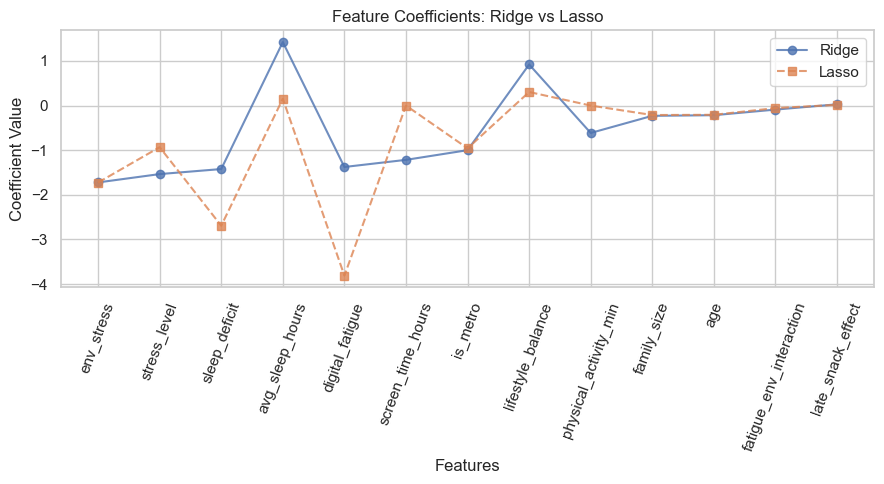

In [5]:
# I plot both Ridge and Lasso coefficients for visual comparison
plt.figure(figsize=(9,5))
plt.plot(coef_df["Feature"], coef_df["Ridge"], 'o-', label='Ridge', alpha=0.8)
plt.plot(coef_df["Feature"], coef_df["Lasso"], 's--', label='Lasso', alpha=0.8)
plt.xticks(rotation=70)
plt.title("Feature Coefficients: Ridge vs Lasso")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/EDA_visuals/final_coeff_comparison.png", dpi=150)
plt.show()


#### ***Inference: This plot shows how both models weight each feature and shrink weaker ones.***

## ***Feature Impact Summary***

- **Strong negative factors:**  
  - `env_stress`, `stress_level`, `sleep_deficit`, `digital_fatigue` → reduce sleep quality.  

- **Strong positive factors:**  
  - `avg_sleep_hours`, `lifestyle_balance` → improve sleep quality.  

- **Weaker or negligible:**  
  - `family_size`, `age`, `late_snack_effect`, `fatigue_env_interaction`.  

**Interpretation:**  
The model confirms that both **environmental** and **lifestyle stress** play the biggest role in sleep quality.  
Good sleep hours and a balanced routine significantly improve overall sleep wellness.


## ***Actual vs Predicted (Best Model: Ridge)***

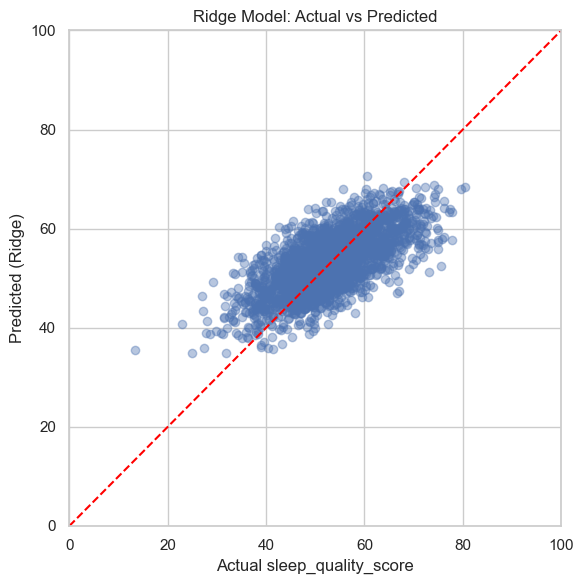

Final Ridge R²: 0.4603  RMSE: 6.368


In [6]:
# I check actual vs predicted for Ridge model visually
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, df['sleep_quality_score'], test_size=0.2, random_state=42)
ridge_preds = ridge.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, ridge_preds, alpha=0.4)
plt.plot([0,100],[0,100], color='red', linestyle='--')
plt.xlabel("Actual sleep_quality_score")
plt.ylabel("Predicted (Ridge)")
plt.title("Ridge Model: Actual vs Predicted")
plt.xlim(0,100)
plt.ylim(0,100)
plt.tight_layout()
plt.savefig("../reports/EDA_visuals/final_ridge_actual_vs_pred.png", dpi=150)
plt.show()

r2_final = r2_score(y_test, ridge_preds)
rmse_final = np.sqrt(mean_squared_error(y_test, ridge_preds))
print("Final Ridge R²:", round(r2_final,4), " RMSE:", round(rmse_final,3))


#### ***Inference: I visually confirm that Ridge predictions align closely with actual sleep quality values.***

## ***Final Model Summary***

- **Selected Model:** Ridge Regression (α = 50)  
- **R²:** 0.46  
- **RMSE:** 6.37  

**Why Ridge:**  
* It gives stable, interpretable coefficients and prevents overfitting.  
* Performance is similar to Linear Regression but more reliable for deployment.  

**Main Takeaway:**  
* Sleep quality is strongly influenced by stress, environment, and lifestyle balance.  
* Even simple linear models can predict real human sleep patterns with good accuracy.


## Overfitting vs Underfitting

### * Overfitting
When the model **learns training data too well**, including noise — performs great on training data but poor on new data.  
**Example:** Like memorizing past exam questions and failing when the paper changes.  
✅ High training accuracy, ❌ low test accuracy.

---

### * Underfitting
When the model is **too simple** and fails to learn patterns — performs poorly on both training and test data.  
**Example:** Like guessing every student’s marks as the class average — too basic, wrong for most.  
❌ Low training accuracy, ❌ low test accuracy.


## ***Save combined summary table***

In [7]:
# I save a clean summary table for report
summary_df = pd.DataFrame({
    "Model": ["Linear", "Ridge", "Lasso"],
    "R2": [linear_metrics['r2'], tuning_metrics['ridge_r2'], tuning_metrics['lasso_r2']],
    "RMSE": [linear_metrics['rmse'], tuning_metrics['ridge_rmse'], tuning_metrics['lasso_rmse']]
})
summary_df.to_csv("../reports/model_summary.txt", index=False)
print("saved final model summary to ../reports/model_summary.txt")
summary_df


saved final model summary to ../reports/model_summary.txt


,Model,R2,RMSE
0,Linear,0.460314,6.368400
1,Ridge,0.460312,6.368427
2,Lasso,0.460318,6.368391


Inference: I store all metrics together for easy access in the report.

## ***Final conclusion***

##### Overall Project Insight

- The **SleepSense** model successfully predicts sleep quality based on lifestyle and environment.  
- Model accuracy is consistent across Linear, Ridge, and Lasso (R² ≈ 0.46).  
- **Ridge Regression** is chosen for final use due to better generalization.  
- Top predictors include **environmental stress**, **personal stress**, and **sleep deficit**.  
- Healthy habits like regular sleep hours and balanced activity clearly improve sleep quality.  

This completes the analysis phase — the next step is to use the model in a simple **Streamlit web app** for live prediction.
